In [32]:
from collections import OrderedDict
import itertools

from sklearn.metrics import confusion_matrix
from torch import nn, optim
from torch.utils.data import DataLoader, sampler
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)

In [14]:
transform_ds = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_ds = datasets.CIFAR10(root="data", download=True, train=True, transform=transform_ds)
test_ds = datasets.CIFAR10(root="data", download=True, train=False, transform=transform_ds)

# Split 
split_point = int(0.8 * len(train_ds))
idx = list(range(len(train_ds)))
train_idx, val_idx = idx[:split_point], idx[split_point:]
train_sampler = sampler.SubsetRandomSampler(train_idx)
val_sampler = sampler.SubsetRandomSampler(val_idx)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_ds, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# Visualize data for sense
plt.imshow(train_ds.data[1])
plt.show()

Files already downloaded and verified
Files already downloaded and verified


In [15]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

class ConvNN(nn.Module):
    
    def __init__(self):
        super(ConvNN, self).__init__()
        
        self.features = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(3, 8, (3, 3))),
            ('relu1', nn.ReLU()),
            ('pool1', nn.MaxPool2d((2, 2))),
            ('conv2', nn.Conv2d(8, 16, (3, 3))),
            ('relu2', nn.ReLU()),
            ('pool2', nn.MaxPool2d((2, 2))),
        ]))
        
        self.classifier = nn.Sequential(OrderedDict([
            ('linear1', nn.Linear(16 * 6 * 6, 256)),
            ('relu3', nn.ReLU()),
            ('drop1', nn.Dropout(p=0.2)),
            ('linear2', nn.Linear(256, 10))            
        ]))
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim =1)
        x = self.classifier(x)
        return x

model = ConvNN().to(device)
print(model)


ConvNN(
  (features): Sequential(
    (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (pool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
    (pool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (linear1): Linear(in_features=576, out_features=256, bias=True)
    (relu3): ReLU()
    (drop1): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=256, out_features=10, bias=True)
  )
)


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9)
epochs = 5

for epoch in range(epochs):
    model.train()
    train_loss, train_acc = 0, 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        output = model.forward(inputs)
        loss = criterion(output, targets)
        train_loss += loss.item() * len(inputs)
        train_acc += (torch.argmax(output, dim=1) == targets).sum().item()
        loss.backward()
        optimizer.step()
    else:
        train_loss /= len(train_idx)
        train_acc /= len(train_idx)
    
    model.eval()
    with torch.no_grad():
        val_loss, val_acc = 0, 0
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model.forward(inputs)
            loss = criterion(output, targets)
            val_loss += loss.item() * len(inputs)
            val_acc += (torch.argmax(output, dim=1) == targets).sum().item()
        else:
            val_loss /= len(val_idx)
            val_acc /= len(val_idx)
    
    scheduler.step()
    
    print(f"Epoch: {epoch+1} | Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | "
          f"Val loss: {val_loss:.5f} | Val acc: {val_acc:.5f}")

Epoch: 1 | Train loss: 0.92266 | Train acc: 0.67392 | Val loss: 1.02041 | Val acc: 0.65250
Epoch: 2 | Train loss: 0.85374 | Train acc: 0.69815 | Val loss: 1.00640 | Val acc: 0.64960
Epoch: 3 | Train loss: 0.80182 | Train acc: 0.71888 | Val loss: 1.00746 | Val acc: 0.65330
Epoch: 4 | Train loss: 0.74935 | Train acc: 0.73870 | Val loss: 1.01015 | Val acc: 0.65720
Epoch: 5 | Train loss: 0.69921 | Train acc: 0.75477 | Val loss: 1.02447 | Val acc: 0.65900


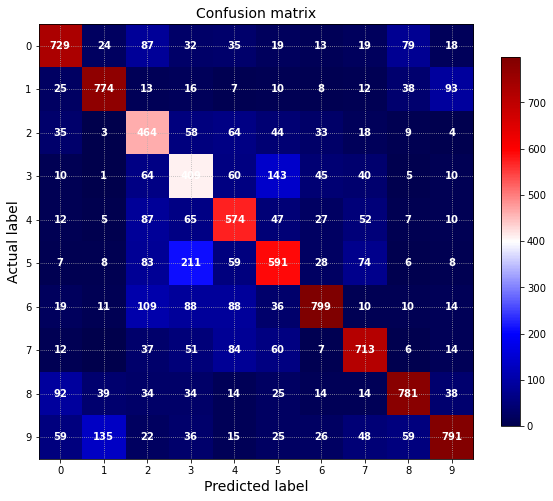

In [33]:
# Check test data
def plot_confusion_matrix(y_pred, y_actual, figsize=(10, 8)):
    """Plot confusion matrix.
    """
    cm = confusion_matrix(y_pred, y_actual)
    cm_norm = cm
    #cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_norm, interpolation='none', cmap='seismic', aspect='equal')
    ax.figure.colorbar(im, ax=ax, shrink=0.85)
    ax.set_title('Confusion matrix', fontsize=14)
    tick_marks = np.arange(10)
    #tick_marks = np.arange(len(encoder.categories_[0]))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    #ax.set_xticklabels(encoder.categories_[0], rotation=90)
    #ax.set_yticklabels(encoder.categories_[0])

    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        if cm_norm[i, j]!=0:
            ax.text(j, i, 
                    format(cm_norm[i, j], '.0f'),
                    horizontalalignment='center', verticalalignment='center', 
                    color='black' if (0.35 < cm_norm[i, j] < 0.65) else 'white',
                    fontsize=10,
                    fontweight=700)

    ax.set_xlabel('Predicted label', fontsize=14)
    ax.set_ylabel('Actual label', fontsize=14)
    ax.grid(linestyle=':')

    
model.eval()
targets_pred = []
targets_actual = []
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    targets_pred.extend(torch.argmax(model.forward(inputs), dim=1).cpu().numpy())
    targets_actual.extend(targets.cpu().numpy())

plot_confusion_matrix(targets_pred, targets_actual)